# Análisis de Mortalidad Fetal en Guatemala (2012-2022) mediante Clustering K-Means

Daniel Chet - 231177, Dulce Ambrosio - 231143

---

### Situación Problemática

Guatemala registra una de las tasas de mortalidad fetal más altas de Latinoamérica. El presente proyecto busca analizar los datos oficiales de **Defunciones Fetales y Nacimientos (2012-2022)** publicados por el Instituto Nacional de Estadística (INE) para identificar patrones y perfiles de riesgo mediante técnicas de análisis exploratorio y minería de datos (K-Means). El objetivo es descubrir si existen segmentos diferenciados de la población materna que presenten mayor vulnerabilidad a la muerte fetal, considerando variables como edad, etnia, escolaridad, asistencia recibida y semanas de gestación.

In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)

## 2. Preprocesamiento de Datos

El preprocesamiento enfrenta varios retos importantes:
- Los archivos `.sav` (SPSS) de diferentes años tienen **nombres de columnas inconsistentes** (mayúsculas, minúsculas, abreviaciones distintas).
- Algunas variables contienen valores como **"Ignorado"** en lugar de datos numéricos.
- Existen **datos atípicos** en edad materna (valores como 99 o 999 que son códigos de "no reportado").
- El peso al nacer viene separado en libras y onzas, y debe consolidarse.
- Las semanas de gestación a veces vienen como texto y requieren conversión numérica.

### 2.0 Exploración de columnas originales

Antes de unificar los datos, es necesario revisar qué columnas tiene cada archivo y detectar cambios en los nombres entre años. Esto nos permite construir el diccionario de mapeo que usaremos después para estandarizar.

In [16]:
# --- Exploración de columnas: Defunciones Fetales ---
import pandas as pd
import os

df_temp = pd.read_spss("DefuncionesFetales/DF2012.sav")
pd.set_option('display.max_columns', None)
print("Columnas de DF2012:")
print(df_temp.columns.tolist())
df_temp.info()

Columnas de DF2012:
['DEPREG', 'MUPREG', 'MESREG', 'AÑOREG', 'DEPOCU', 'MUPOCU', 'AREAG', 'SEXO', 'DIAOCU', 'MESOCU', 'TIPAR', 'CLAPAR', 'VIAPAR', 'SEMGES', 'EDADM', 'PAISREM', 'DEPREM', 'MUPREM', 'GRETNM', 'ESCIVM', 'NACIOM', 'ESCOLAM', 'OCUPAM', 'CAUDEF', 'ASISREC', 'SITIOOCU', 'TOHITE', 'TOHINM', 'TOHIVI']
<class 'pandas.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DEPREG    3157 non-null   category
 1   MUPREG    3157 non-null   category
 2   MESREG    3157 non-null   category
 3   AÑOREG    3157 non-null   float64 
 4   DEPOCU    3157 non-null   category
 5   MUPOCU    3157 non-null   category
 6   AREAG     3157 non-null   category
 7   SEXO      3157 non-null   category
 8   DIAOCU    3157 non-null   float64 
 9   MESOCU    3157 non-null   category
 10  TIPAR     3157 non-null   category
 11  CLAPAR    3157 non-null   category
 12  VIAPAR    3157 non-null   ca

In [17]:
# --- Comparación de columnas entre años: Defunciones Fetales ---
ROJO = "\033[91m"
VERDE = "\033[92m"
AMARILLO = "\033[93m"
AZUL = "\033[94m"
RESET = "\033[0m"

carpeta = "DefuncionesFetales" 
archivos = [f for f in os.listdir(carpeta) if f.endswith('.sav')]
archivos.sort()

df_prev = pd.read_spss(os.path.join(carpeta, archivos[0]))
cols_prev = set(df_prev.columns)

print(f"{AZUL}Base: {archivos[0]} tiene {len(cols_prev)} columnas.{RESET}")

for archivo in archivos[1:]:
    print(f"\n{AZUL}--- Comparando {archivo} vs año anterior ---{RESET}")
    
    try:
        df_actual = pd.read_spss(os.path.join(carpeta, archivo))
        cols_actual = set(df_actual.columns)
        
        nuevas = cols_actual - cols_prev
        if nuevas:
            print(f"{AMARILLO}AGREGADAS: {nuevas}{RESET}")
            
        perdidas = cols_prev - cols_actual
        if perdidas:
            print(f"{ROJO}ELIMINADAS (o cambiaron nombre): {perdidas}{RESET}")
            
        if not nuevas and not perdidas:
            print(f"{VERDE}Estructura idéntica.{RESET}")
            
        cols_prev = cols_actual
        
    except Exception as e:
        print(f"{ROJO}Error leyendo {archivo}: {e}{RESET}")

Base: DF2012.sav tiene 29 columnas.

--- Comparando DF2013.sav vs año anterior ---
AGREGADAS: {'PUEBLOPM', 'CIUOMAD'}
ELIMINADAS (o cambiaron nombre): {'OCUPAM', 'GRETNM'}

--- Comparando DF2014.sav vs año anterior ---
Estructura idéntica.

--- Comparando DF2015.sav vs año anterior ---
AGREGADAS: {'NACIONM', 'AÑOOCU'}
ELIMINADAS (o cambiaron nombre): {'NACIOM'}

--- Comparando DF2016.sav vs año anterior ---
Estructura idéntica.

--- Comparando DF2017.sav vs año anterior ---
ELIMINADAS (o cambiaron nombre): {'AREAG'}

--- Comparando DF2018.sav vs año anterior ---
Estructura idéntica.

--- Comparando DF2019.sav vs año anterior ---
Estructura idéntica.

--- Comparando DF2020.sav vs año anterior ---
Estructura idéntica.

--- Comparando DF2021.sav vs año anterior ---
Estructura idéntica.

--- Comparando DF2022.sav vs año anterior ---
Estructura idéntica.


In [18]:
# --- Exploración de columnas: Nacimientos ---
df_temp = pd.read_spss("Nacimientos/N2012.sav")
pd.set_option('display.max_columns', None)
print("Columnas de N2012:")
print(df_temp.columns.tolist())
df_temp.info()

Columnas de N2012:
['Depreg', 'Mupreg', 'Mesreg', 'Añoreg', 'Depocu', 'Mupocu', 'Libras', 'Onzas', 'Diaocu', 'Mesocu', 'Sexo', 'Tipar', 'Edadp', 'Paisrep', 'Deprep', 'Muprep', 'Gretnp', 'Escivp', 'Paisnacp', 'Depnap', 'Mupnap', 'Naciop', 'Escolap', 'Ocupap', 'Edadm', 'Paisrem', 'Deprem', 'Muprem', 'grupetma', 'Escivm', 'Paisnacm', 'Depnam', 'munnam', 'Naciom', 'Escolam', 'Ocupam', 'Asisrec', 'Sitioocu', 'Tohite', 'Tohinm', 'Tohivi']
<class 'pandas.DataFrame'>
RangeIndex: 388613 entries, 0 to 388612
Data columns (total 41 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   Depreg    388613 non-null  category
 1   Mupreg    388613 non-null  category
 2   Mesreg    388613 non-null  category
 3   Añoreg    388613 non-null  float64 
 4   Depocu    388613 non-null  category
 5   Mupocu    388613 non-null  category
 6   Libras    388613 non-null  category
 7   Onzas     388613 non-null  category
 8   Diaocu    388613 non-null  float64 
 9   Mesocu 

In [19]:
# --- Comparación de columnas entre años: Nacimientos ---
carpeta = "Nacimientos" 
archivos = [f for f in os.listdir(carpeta) if f.endswith('.sav')]
archivos.sort()

df_prev = pd.read_spss(os.path.join(carpeta, archivos[0]))
cols_prev = set(df_prev.columns)

print(f"{AZUL}Base: {archivos[0]} tiene {len(cols_prev)} columnas.{RESET}")

for archivo in archivos[1:]:
    print(f"\n{AZUL}--- Comparando {archivo} vs año anterior ---{RESET}")
    
    try:
        df_actual = pd.read_spss(os.path.join(carpeta, archivo))
        cols_actual = set(df_actual.columns)
        
        nuevas = cols_actual - cols_prev
        if nuevas:
            print(f"{AMARILLO}AGREGADAS: {nuevas}{RESET}")
            
        perdidas = cols_prev - cols_actual
        if perdidas:
            print(f"{ROJO}ELIMINADAS (o cambiaron nombre): {perdidas}{RESET}")
            
        if not nuevas and not perdidas:
            print(f"{VERDE}Estructura idéntica.{RESET}")
            
        cols_prev = cols_actual
        
    except Exception as e:
        print(f"{ROJO}Error leyendo {archivo}: {e}{RESET}")

Base: N2012.sav tiene 41 columnas.

--- Comparando N2013.sav vs año anterior ---
AGREGADAS: {'Mupnam', 'Ciuopad', 'Ciuomad', 'PuebloPM', 'PuebloPP'}
ELIMINADAS (o cambiaron nombre): {'grupetma', 'munnam', 'Gretnp', 'Ocupam', 'Ocupap'}

--- Comparando N2014.sav vs año anterior ---
AGREGADAS: {'Munpnap', 'ciuomad', 'Ocupap'}
ELIMINADAS (o cambiaron nombre): {'Ciuopad', 'Naciom', 'Mupnap', 'Ciuomad', 'Naciop'}

--- Comparando N2015.sav vs año anterior ---
AGREGADAS: {'TipoIns', 'Ocupam', 'Añoocu', 'ViaPar'}
ELIMINADAS (o cambiaron nombre): {'ciuomad'}

--- Comparando N2016.sav vs año anterior ---
Estructura idéntica.

--- Comparando N2017.sav vs año anterior ---
Estructura idéntica.

--- Comparando N2018.sav vs año anterior ---
Estructura idéntica.

--- Comparando N2019.sav vs año anterior ---
Estructura idéntica.

--- Comparando N2020.sav vs año anterior ---
Estructura idéntica.

--- Comparando N2021.sav vs año anterior ---
AGREGADAS: {'Mupnap'}
ELIMINADAS (o cambiaron nombre): {'Munpnap

### 2.1 Lectura de archivos de Nacimientos (2012-2022)

In [20]:
# --- CONFIGURACIÓN ---
carpeta_nacimientos = "./Nacimientos/"

# DICCIONARIO DE COLUMNAS A CONSERVAR
cols_nacimientos_map = {
    # --- Geografía (Residencia es mejor que Ocurrencia para análisis social) ---
    'Departamento': ['Deprem', 'DEPREM'],
    'Municipio': ['Muprem', 'MUPREM'],
    
    # --- Tiempo ---
    'Anio': ['Añoocu', 'AÑOOCU', 'Añoreg', 'AÑOREG', 'Anoreg'],
    'Mes': ['Mesocu', 'MESOCU', 'Mesreg', 'MESREG'],
    
    # --- Datos Madre ---
    'Edad_Madre': ['Edadm', 'EDADM'],
    'Estado_Civil': ['Escivm', 'ESCIVM'],
    'Escolaridad': ['Escolam', 'ESCOLAM'],
    'Total_Hijos': ['Tohite', 'TOHITE'],
    'Pueblo_Etnia': ['PuebloPM', 'PUEBLOPM', 'Pueblopm', 'grupetma', 'GRUPETMA'],
    
    # --- Datos Bebé ---
    'Sexo': ['Sexo', 'SEXO'],
    'Tipo_Parto': ['Tipar', 'TIPAR'],
    'Sitio_Ocurrencia': ['Sitioocu', 'SITIOOCU'],
    'Asistencia_Recibida': ['Asisrec', 'ASISREC'],
    
    # --- Peso (temporales para cálculo) ---
    'Libras_Temp': ['Libras', 'LIBRAS'],
    'Onzas_Temp': ['Onzas', 'ONZAS']
}

def procesar_nacimientos(carpeta, diccionario_map):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.sav')]
    archivos.sort()
    archivos = [f for f in archivos if any(str(y) in f for y in range(2012, 2023))]
    
    lista_dfs = []
    print(f"Procesando {len(archivos)} archivos de Nacimientos (2012-2022)...")
    
    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)
        try:
            df_raw = pd.read_spss(ruta, convert_categoricals=True)
            df_limpio = pd.DataFrame()
            
            for nombre_final, variantes in diccionario_map.items():
                col_encontrada = None
                for col_real in df_raw.columns:
                    if col_real.upper() in [v.upper() for v in variantes]:
                        col_encontrada = col_real
                        break
                if col_encontrada:
                    df_limpio[nombre_final] = df_raw[col_encontrada]
                else:
                    df_limpio[nombre_final] = np.nan
            
            lista_dfs.append(df_limpio)
            print(f"  -> {archivo}: OK")
        except Exception as e:
            print(f"  ERROR en {archivo}: {e}")

    if not lista_dfs:
        return None

    df_final = pd.concat(lista_dfs, ignore_index=True)
    
    print("\nCalculando pesos y limpiando...")
    df_final['Libras_Temp'] = pd.to_numeric(df_final['Libras_Temp'], errors='coerce').fillna(0)
    df_final['Onzas_Temp'] = pd.to_numeric(df_final['Onzas_Temp'], errors='coerce').fillna(0)
    df_final['Peso_Libras'] = df_final['Libras_Temp'] + (df_final['Onzas_Temp'] / 16)
    df_final = df_final.drop(columns=['Libras_Temp', 'Onzas_Temp'])
    df_final = df_final[df_final['Peso_Libras'] > 0]

    return df_final

# --- EJECUTAR ---
df_nacimientos = procesar_nacimientos(carpeta_nacimientos, cols_nacimientos_map)

print("\n--- RESUMEN FINAL ---")
print(df_nacimientos.info())
print("\nPrimeras 5 filas:")
print(df_nacimientos.head())

Procesando 11 archivos de Nacimientos (2012-2022)...
  -> N2012.sav: OK
  -> N2013.sav: OK
  -> N2014.sav: OK
  -> N2015.sav: OK
  -> N2016.sav: OK
  -> N2017.sav: OK
  -> N2018.sav: OK
  -> N2019.sav: OK
  -> N2020.sav: OK
  -> N2021.sav: OK
  -> N2022.sav: OK

Calculando pesos y limpiando...

--- RESUMEN FINAL ---
<class 'pandas.DataFrame'>
Index: 4103769 entries, 0 to 4107968
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   Departamento         category
 1   Municipio            object  
 2   Anio                 float64 
 3   Mes                  category
 4   Edad_Madre           object  
 5   Estado_Civil         category
 6   Escolaridad          str     
 7   Total_Hijos          object  
 8   Pueblo_Etnia         str     
 9   Sexo                 category
 10  Tipo_Parto           str     
 11  Sitio_Ocurrencia     str     
 12  Asistencia_Recibida  str     
 13  Peso_Libras          float64 
dtypes: category(4), floa

### 2.2 Lectura de archivos de Defunciones Fetales (2012-2022)

In [21]:
import pandas as pd
import os
import numpy as np

# --- CONFIGURACIÓN ---
# Ajusta la ruta a donde tengas tus archivos de DEFUNCIONES
carpeta_defunciones = "./DefuncionesFetales/" 

# DICCIONARIO DE COLUMNAS A CONSERVAR (Defunciones Fetales)
cols_defunciones_map = {
    # --- Geografía (Usamos Residencia para cruzar con Nacimientos) ---
    'Departamento': ['DEPREM', 'Deprem'],
    'Municipio': ['MUPREM', 'Muprem'],
    
    # --- Tiempo ---
    # Prioridad: Ocurrencia. Si no existe, Registro.
    'Anio': ['AÑOOCU', 'Añoocu', 'AÑOREG', 'Añoreg', 'ANOREG'],
    'Mes': ['MESOCU', 'Mesocu', 'MESREG', 'Mesreg'],
    
    # --- Datos Madre ---
    'Edad_Madre': ['EDADM', 'Edadm'],
    'Estado_Civil': ['ESCIVM', 'Escivm'],
    'Escolaridad': ['ESCOLAM', 'Escolam'],
    'Total_Hijos': ['TOHITE', 'Tohite'],
    # El cambio difícil: GRETNM -> PUEBLOPM -> NACIONM (a veces)
    'Pueblo_Etnia': ['PUEBLOPM', 'PuebloPM', 'Pueblopm', 'GRETNM', 'Gretnm'],
    
    # --- Datos Feto/Evento ---
    'Sexo': ['SEXO', 'Sexo'],
    'Tipo_Parto': ['TIPAR', 'Tipar'],
    'Sitio_Ocurrencia': ['SITIOOCU', 'Sitioocu'],
    'Asistencia_Recibida': ['ASISREC', 'Asisrec'],
    'Causa_Defuncion': ['CAUDEF', 'Caudef'], # Muy importante en defunciones
    
    # --- Variable Numérica Crítica ---
    'Semanas_Gestacion': ['SEMGES', 'Semges']
}

def procesar_defunciones(carpeta, diccionario_map):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.sav')]
    archivos.sort()
    
    # Filtro 2012-2022
    archivos = [f for f in archivos if any(str(y) in f for y in range(2012, 2023))]
    
    lista_dfs = []
    print(f"Procesando {len(archivos)} archivos de Defunciones (2012-2022)...")
    
    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)
        try:
            # Leer archivo con etiquetas
            df_raw = pd.read_spss(ruta, convert_categoricals=True)
            
            df_limpio = pd.DataFrame()
            
            for nombre_final, variantes in diccionario_map.items():
                col_encontrada = None
                for col_real in df_raw.columns:
                    if col_real.upper() in [v.upper() for v in variantes]:
                        col_encontrada = col_real
                        break
                
                if col_encontrada:
                    df_limpio[nombre_final] = df_raw[col_encontrada]
                else:
                    df_limpio[nombre_final] = np.nan
            
            lista_dfs.append(df_limpio)
            print(f"  -> {archivo}: OK")
            
        except Exception as e:
            print(f"  ERROR en {archivo}: {e}")

    if not lista_dfs:
        return None

    # 1. Unir todo
    df_final = pd.concat(lista_dfs, ignore_index=True)
    
    # 2. LIMPIEZA ESPECÍFICA DE DEFUNCIONES
    print("\nLimpiando datos numéricos...")
    
    # Semanas de Gestación: Debe ser numérico.
    # A veces viene como "Ignorado" o texto. 'coerce' lo vuelve NaN.
    df_final['Semanas_Gestacion'] = pd.to_numeric(df_final['Semanas_Gestacion'], errors='coerce')
    
    # Edad Madre: Asegurar numérico
    df_final['Edad_Madre'] = pd.to_numeric(df_final['Edad_Madre'], errors='coerce')
    
    # Eliminar registros sin semanas de gestación válidas (opcional, pero recomendado para K-Means)
    df_final = df_final.dropna(subset=['Semanas_Gestacion'])

    return df_final

# --- EJECUTAR ---
df_defunciones = procesar_defunciones(carpeta_defunciones, cols_defunciones_map)

# Verificación
if df_defunciones is not None:
    print("\n--- RESUMEN FINAL DEFUNCIONES ---")
    print(df_defunciones.info())
    print("\nPrimeras 5 filas:")
    print(df_defunciones.head())

Procesando 11 archivos de Defunciones (2012-2022)...
  -> DF2012.sav: OK
  -> DF2013.sav: OK
  -> DF2014.sav: OK
  -> DF2015.sav: OK
  -> DF2016.sav: OK
  -> DF2017.sav: OK
  -> DF2018.sav: OK
  -> DF2019.sav: OK
  -> DF2020.sav: OK
  -> DF2021.sav: OK
  -> DF2022.sav: OK

Limpiando datos numéricos...

--- RESUMEN FINAL DEFUNCIONES ---
<class 'pandas.DataFrame'>
Index: 28897 entries, 0 to 31606
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Departamento         28897 non-null  str     
 1   Municipio            28897 non-null  str     
 2   Anio                 28897 non-null  float64 
 3   Mes                  28897 non-null  category
 4   Edad_Madre           28163 non-null  float64 
 5   Estado_Civil         28897 non-null  category
 6   Escolaridad          28897 non-null  str     
 7   Total_Hijos          28602 non-null  object  
 8   Pueblo_Etnia         28897 non-null  str     
 9   Sex

### 2.3 Estandarización de nombres y limpieza de variables numéricas

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo (para que se vean profesionales como en el notebook de clase)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [23]:
import pandas as pd
import numpy as np

# 1. Limpiar Edad en Nacimientos (Convertir "Ignorado" a NaN)
# errors='coerce' fuerza a que cualquier texto se vuelva un número vacío (NaN)
df_nacimientos['Edad_Madre'] = pd.to_numeric(df_nacimientos['Edad_Madre'], errors='coerce')

# 2. Eliminar las filas que quedaron vacías (NaN) en esa columna
df_nacimientos = df_nacimientos.dropna(subset=['Edad_Madre'])

# 3. (Opcional pero recomendado) Hacer lo mismo con Defunciones por seguridad
df_defunciones['Edad_Madre'] = pd.to_numeric(df_defunciones['Edad_Madre'], errors='coerce')
df_defunciones = df_defunciones.dropna(subset=['Edad_Madre'])

print("Limpieza de Edad completada.")

Limpieza de Edad completada.


In [24]:
print("--- Limpieza de Valores Atípicos en Peso ---")

# Ver cuántos datos raros hay antes de borrar
pesos_raros = df_nacimientos[df_nacimientos['Peso_Libras'] > 15].shape[0]
print(f"Se encontraron {pesos_raros} registros con peso mayor a 15 libras. Serán eliminados.")

# Filtrar para mantener solo pesos biológicamente posibles (ej. entre 1 y 15 libras)
df_nacimientos = df_nacimientos[(df_nacimientos['Peso_Libras'] >= 1) & (df_nacimientos['Peso_Libras'] <= 15)]

print("Limpieza de peso completada. Los QQ-Plots ahora se verán normales.")

--- Limpieza de Valores Atípicos en Peso ---
Se encontraron 270 registros con peso mayor a 15 libras. Serán eliminados.
Limpieza de peso completada. Los QQ-Plots ahora se verán normales.


In [25]:
print("--- Estandarización Profunda de Variables Categóricas ---")

# 1. Diccionario extendido para Asistencia Recibida
mapeo_asistencia_ext = {
    'Médico': 'Médica',
    'Medico': 'Médica',
    'Empírico': 'Empírica',
    'Empirico': 'Empírica',
    'Paramédico': 'Paramédica',
    'Paramedico': 'Paramédica',
    'Ninguno': 'Ninguna',
    'Ignorada': 'Ignorado'
}

# 2. Diccionario extendido para Etnia
# Asumimos 'Indigena' como 'Maya' (el grupo mayoritario) y 'No indigena' como 'Mestizo / Ladino'
mapeo_etnia_ext = {
    'Xinca': 'Xinka',
    'Indigena': 'Maya',
    'No indigena': 'Mestizo / Ladino'
}

# 3. Aplicar los mapeos a Nacimientos
df_nacimientos['Asistencia_Recibida'] = df_nacimientos['Asistencia_Recibida'].replace(mapeo_asistencia_ext)
df_nacimientos['Pueblo_Etnia'] = df_nacimientos['Pueblo_Etnia'].replace(mapeo_etnia_ext)

# 4. Aplicar los mapeos a Defunciones (para mantener coherencia entre ambas tablas)
df_defunciones['Asistencia_Recibida'] = df_defunciones['Asistencia_Recibida'].replace(mapeo_asistencia_ext)
df_defunciones['Pueblo_Etnia'] = df_defunciones['Pueblo_Etnia'].replace(mapeo_etnia_ext)

print("¡Limpieza profunda completada!")

--- Estandarización Profunda de Variables Categóricas ---
¡Limpieza profunda completada!


In [26]:
import pandas as pd
import numpy as np

# Función para limpiar columnas numéricas a la fuerza
def limpiar_numericos(df, columnas):
    for col in columnas:
        # Convertir a numérico, errores se vuelven NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# 1. Definir las columnas numéricas que vas a usar
cols_num_nac = ['Edad_Madre', 'Peso_Libras', 'Total_Hijos']
cols_num_def = ['Edad_Madre', 'Semanas_Gestacion', 'Total_Hijos']

# 2. Aplicar limpieza
df_nacimientos = limpiar_numericos(df_nacimientos, cols_num_nac)
df_defunciones = limpiar_numericos(df_defunciones, cols_num_def)

# 3. Eliminar filas que quedaron vacías por tener datos inválidos
df_nacimientos = df_nacimientos.dropna(subset=cols_num_nac)
df_defunciones = df_defunciones.dropna(subset=cols_num_def)

print("¡Limpieza de variables numéricas completada!")

¡Limpieza de variables numéricas completada!


## 3. Análisis Exploratorio (EDA)

En esta sección se describen las variables numéricas y categóricas principales de ambos conjuntos de datos, evaluando su distribución, normalidad y posibles datos atípicos.

### 3.1 Descripción del conjunto de datos

In [27]:
# Función para describir un dataset
def describir_dataset(df, nombre):
    print(f"--- DESCRIPCIÓN DE {nombre.upper()} ---")
    print(f"Total de Observaciones (Filas): {df.shape[0]}")
    print(f"Total de Variables (Columnas): {df.shape[1]}")
    print("\nTipos de Variables:")
    print(df.dtypes)
    print("\n")

# Ejecutar para ambos
describir_dataset(df_nacimientos, "Nacimientos")
describir_dataset(df_defunciones, "Defunciones Fetales")

--- DESCRIPCIÓN DE NACIMIENTOS ---
Total de Observaciones (Filas): 4042574
Total de Variables (Columnas): 14

Tipos de Variables:
Departamento           category
Municipio                object
Anio                    float64
Mes                    category
Edad_Madre              float64
Estado_Civil           category
Escolaridad                 str
Total_Hijos             float64
Pueblo_Etnia                str
Sexo                   category
Tipo_Parto                  str
Sitio_Ocurrencia            str
Asistencia_Recibida         str
Peso_Libras             float64
dtype: object


--- DESCRIPCIÓN DE DEFUNCIONES FETALES ---
Total de Observaciones (Filas): 15430
Total de Variables (Columnas): 15

Tipos de Variables:
Departamento                str
Municipio                   str
Anio                    float64
Mes                    category
Edad_Madre              float64
Estado_Civil           category
Escolaridad                 str
Total_Hijos             float64
Pueblo_Etnia  

### 3.2 Resumen estadístico y prueba de normalidad

C:\Users\danie\AppData\Local\Temp\ipykernel_24056\1066738007.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Tipo", y="Edad", data=df_comparativo, palette=["skyblue", "salmon"])


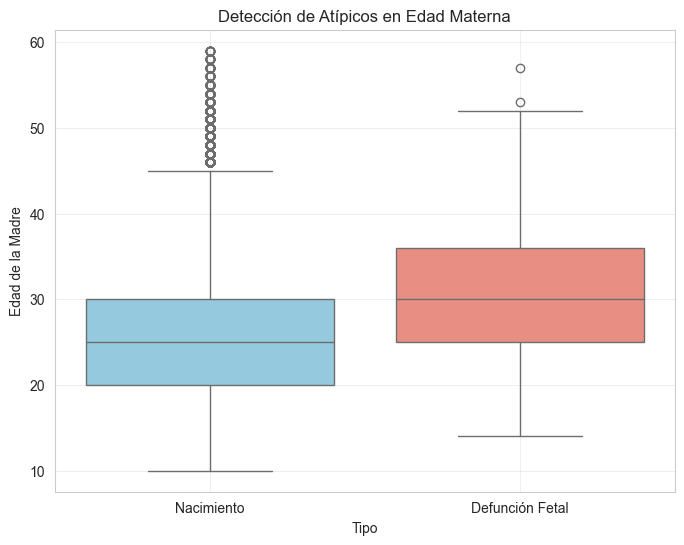

In [29]:
# 1. Limpieza de Edad Lógica
# Eliminamos madres con edad mayor a 55 años (probablemente son errores 99 o 999)
# y menores a 10 años (errores de registro)
df_nacimientos = df_nacimientos[df_nacimientos['Edad_Madre'] < 80]
df_nacimientos = df_nacimientos[df_nacimientos['Edad_Madre'] > 1]

df_defunciones = df_defunciones[df_defunciones['Edad_Madre'] < 80]
df_defunciones = df_defunciones[df_defunciones['Edad_Madre'] > 1]

# 2. Generar el Boxplot de nuevo
# (Repetimos el código de preparación para la gráfica)
df_nac_temp = pd.DataFrame({'Edad': df_nacimientos['Edad_Madre'], 'Tipo': 'Nacimiento'})
df_def_temp = pd.DataFrame({'Edad': df_defunciones['Edad_Madre'], 'Tipo': 'Defunción Fetal'})

df_comparativo = pd.concat([df_nac_temp, df_def_temp])

plt.figure(figsize=(8, 6))
sns.boxplot(x="Tipo", y="Edad", data=df_comparativo, palette=["skyblue", "salmon"])

plt.title("Detección de Atípicos en Edad Materna")
plt.ylabel("Edad de la Madre")
plt.grid(True, alpha=0.3)
plt.show()

# Limpiar temporales
del df_nac_temp, df_def_temp, df_comparativo

--- ESTADÍSTICAS DESCRIPTIVAS: NACIMIENTOS ---
       Edad_Madre  Peso_Libras  Total_Hijos
count  4042551.00   4042551.00   4042551.00
mean        25.63         6.70         2.58
std          6.56         1.08         1.93
min         10.00         1.00         1.00
25%         20.00         6.00         1.00
50%         25.00         6.75         2.00
75%         30.00         7.31         3.00
max         59.00        11.94        18.00

Asimetría (Skewness):
Edad_Madre     0.56
Peso_Libras   -0.30
Total_Hijos    1.83
dtype: float64


--- ESTADÍSTICAS DESCRIPTIVAS: DEFUNCIONES ---
       Edad_Madre  Semanas_Gestacion  Total_Hijos
count    15430.00           15430.00     15430.00
mean        30.34              34.90         3.93
std          6.87               5.35         2.30
min         14.00               1.00         1.00
25%         25.00              32.00         2.00
50%         30.00              36.00         3.00
75%         36.00              39.00         5.00
max       

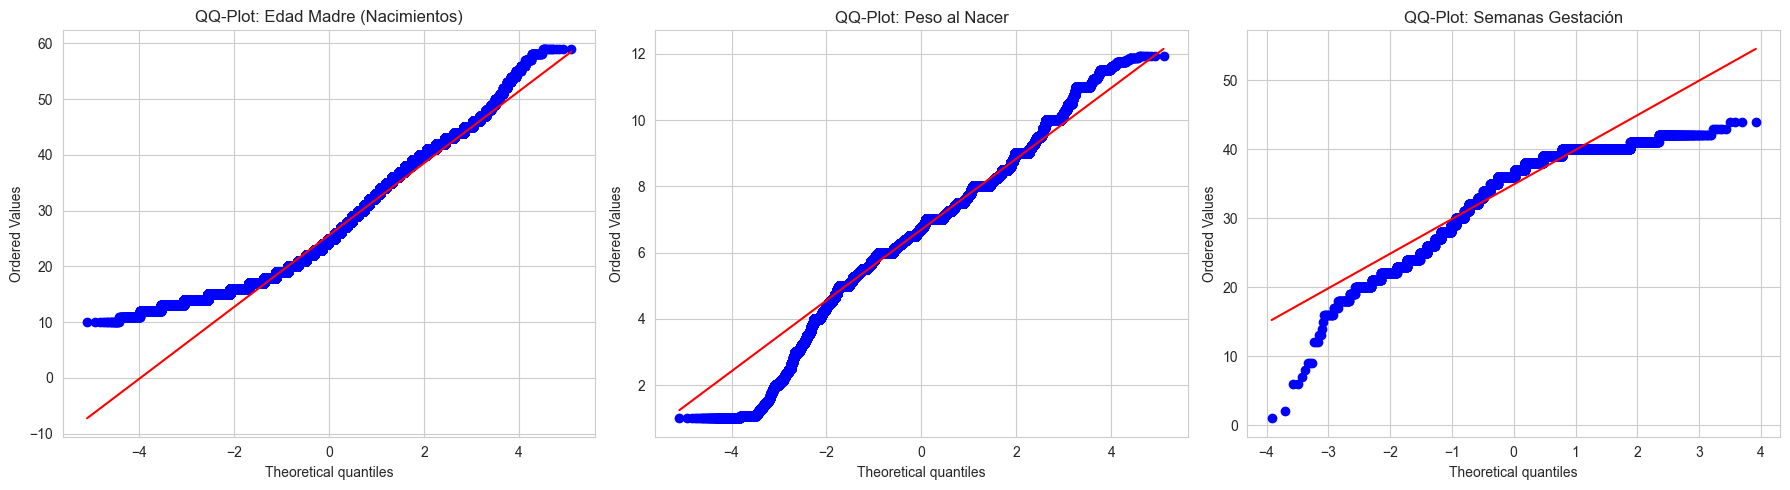

In [30]:
# 2. Resumen Estadístico (Media, Mediana, Desviación)
print("--- ESTADÍSTICAS DESCRIPTIVAS: NACIMIENTOS ---")
cols_num_nac = ['Edad_Madre', 'Peso_Libras', 'Total_Hijos']
print(df_nacimientos[cols_num_nac].describe().round(2))
print("\nAsimetría (Skewness):")
print(df_nacimientos[cols_num_nac].skew().round(2))

print("\n\n--- ESTADÍSTICAS DESCRIPTIVAS: DEFUNCIONES ---")
cols_num_def = ['Edad_Madre', 'Semanas_Gestacion', 'Total_Hijos']
print(df_defunciones[cols_num_def].describe().round(2))
print("\nAsimetría (Skewness):")
print(df_defunciones[cols_num_def].skew().round(2))

# 2. Prueba Visual de Normalidad (QQ-Plots)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

stats.probplot(df_nacimientos['Edad_Madre'], dist="norm", plot=axes[0])
axes[0].set_title("QQ-Plot: Edad Madre (Nacimientos)")

stats.probplot(df_nacimientos['Peso_Libras'], dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot: Peso al Nacer")

stats.probplot(df_defunciones['Semanas_Gestacion'], dist="norm", plot=axes[2])
axes[2].set_title("QQ-Plot: Semanas Gestación")

plt.tight_layout()
plt.show()

### Interpretación de la normalidad

- **Peso al Nacer** presenta una distribución aproximadamente normal con ligera asimetría negativa (colas hacia pesos bajos).
- **Semanas de Gestación** muestra un sesgo marcado: la mayoría de defunciones ocurren antes de las 40 semanas (pretérmino), lo que confirma que la prematurez es un factor dominante.
- **Edad de la Madre** tiene una distribución sesgada a la derecha, con mayor concentración entre los 18 y 30 años, pero con una cola derecha que sugiere que madres de mayor edad también están representadas en defunciones fetales.

### 3.3 Gráficas de distribución

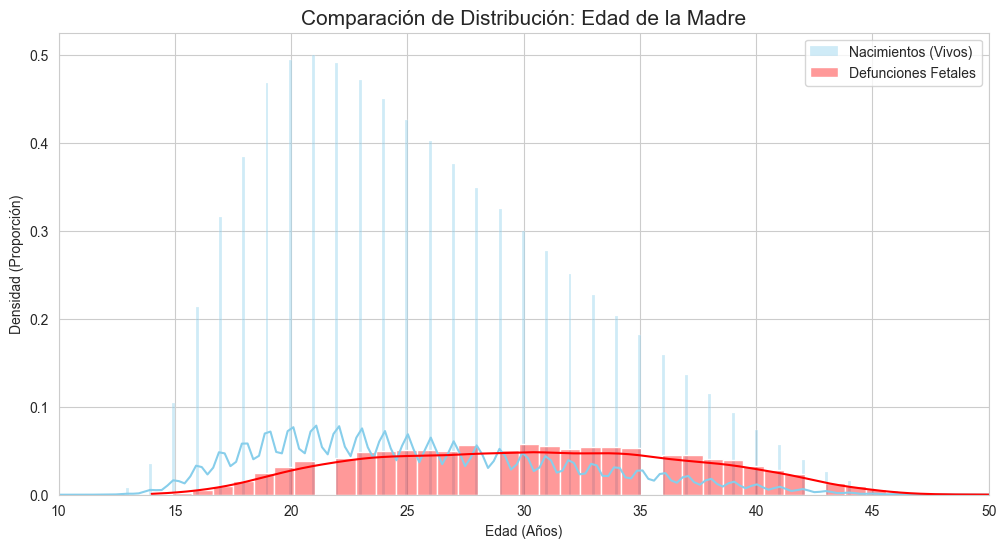

In [31]:
# --- Gráfico 1: Comparación de Edad de la Madre (Histograma + KDE) ---
plt.figure(figsize=(12, 6))

# Histograma de Nacimientos (Azul)
sns.histplot(
    data=df_nacimientos, 
    x="Edad_Madre", 
    kde=True, 
    color="skyblue", 
    label="Nacimientos (Vivos)", 
    stat="density", 
    common_norm=False,
    alpha=0.4
)

# Histograma de Defunciones Fetales (Rojo)
sns.histplot(
    data=df_defunciones, 
    x="Edad_Madre", 
    kde=True, 
    color="red", 
    label="Defunciones Fetales", 
    stat="density", 
    common_norm=False,
    alpha=0.4
)

plt.title("Comparación de Distribución: Edad de la Madre", fontsize=15)
plt.xlabel("Edad (Años)")
plt.ylabel("Densidad (Proporción)")
plt.legend()
plt.xlim(10, 50)
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_24056\2491936839.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Tipo", y="Edad", data=df_comparativo, palette=["skyblue", "salmon"])


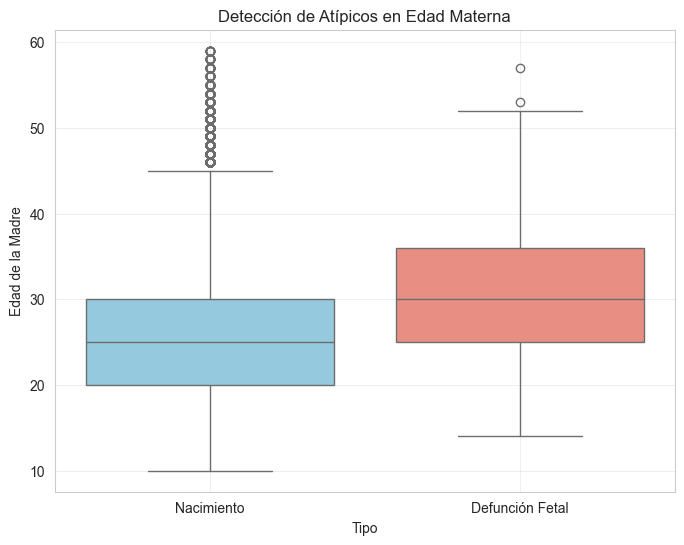

In [32]:
# --- Gráfico 2: Detección de Datos Atípicos (Boxplots) ---
df_nac_temp = pd.DataFrame({'Edad': df_nacimientos['Edad_Madre'], 'Tipo': 'Nacimiento'})
df_def_temp = pd.DataFrame({'Edad': df_defunciones['Edad_Madre'], 'Tipo': 'Defunción Fetal'})
df_comparativo = pd.concat([df_nac_temp, df_def_temp])

plt.figure(figsize=(8, 6))
sns.boxplot(x="Tipo", y="Edad", data=df_comparativo, palette=["skyblue", "salmon"])
plt.title("Detección de Atípicos en Edad Materna")
plt.ylabel("Edad de la Madre")
plt.grid(True, alpha=0.3)
plt.show()

del df_nac_temp, df_def_temp, df_comparativo

### Hallazgo visual

Al superponer las distribuciones de edad, se observa que la curva de defunciones fetales (roja) presenta una cola derecha ligeramente más gruesa que la de nacimientos vivos (azul). Esto sugiere que **a mayor edad de la madre, aumenta proporcionalmente el riesgo de muerte fetal**, especialmente a partir de los 35 años. Los boxplots confirman que la mediana de edad en defunciones es ligeramente superior.

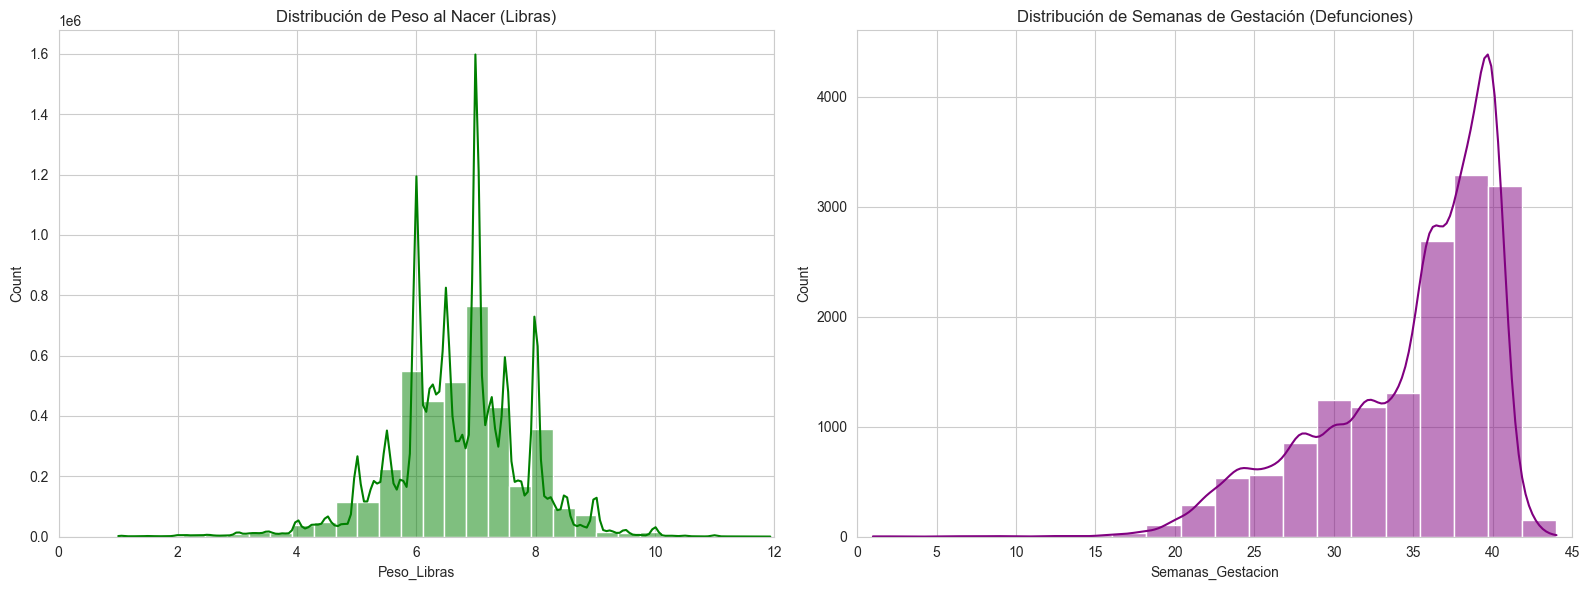

In [33]:
# --- Gráfico 3: Distribución del Peso y Semanas de Gestación ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico A: Distribución del Peso (Solo Nacimientos)
sns.histplot(
    data=df_nacimientos, 
    x="Peso_Libras", 
    bins=30, 
    kde=True, 
    color="green", 
    ax=axes[0]
)
axes[0].set_title("Distribución de Peso al Nacer (Libras)")
axes[0].set_xlim(0, 12)

# Gráfico B: Distribución de Semanas de Gestación (Solo Defunciones)
sns.histplot(
    data=df_defunciones, 
    x="Semanas_Gestacion", 
    bins=20, 
    kde=True, 
    color="purple", 
    ax=axes[1]
)
axes[1].set_title("Distribución de Semanas de Gestación (Defunciones)")
axes[1].set_xlim(0, 45)

plt.tight_layout()
plt.show()

### 3.4 Tablas de Frecuencia (Variables Categóricas)

In [34]:
def tabla_frecuencia(df, columna, nombre_col):
    conteo = df[columna].value_counts()
    porcentaje = df[columna].value_counts(normalize=True) * 100
    tabla = pd.DataFrame({
        'Frecuencia': conteo,
        'Porcentaje (%)': porcentaje.round(2)
    })
    print(f"\n--- {nombre_col.upper()} ---")
    print(tabla.head(10))

# Variables de interés
vars_interes = {
    'Departamento': 'Departamento',
    'Pueblo_Etnia': 'Pertenencia Étnica',
    'Escolaridad': 'Nivel Educativo',
    'Sitio_Ocurrencia': 'Lugar del Evento',
    'Asistencia_Recibida': 'Tipo de Asistencia'
}

print("=== FRECUENCIAS EN DEFUNCIONES FETALES ===")
for col_real, nombre in vars_interes.items():
    tabla_frecuencia(df_defunciones, col_real, nombre)

print("\n\n=== FRECUENCIAS EN NACIMIENTOS ===")
tabla_frecuencia(df_nacimientos, 'Asistencia_Recibida', 'Asistencia en Nacimientos')
tabla_frecuencia(df_nacimientos, 'Pueblo_Etnia', 'Etnia en Nacimientos')

=== FRECUENCIAS EN DEFUNCIONES FETALES ===

--- DEPARTAMENTO ---
                Frecuencia  Porcentaje (%)
Departamento                              
Guatemala             2753           17.84
Alta Verapaz          2538           16.45
Quiche                1515            9.82
Chimaltenango         1183            7.67
Solola                 854            5.53
Quetzaltenango         792            5.13
Totonicapan            739            4.79
Huehuetenango          702            4.55
Baja Verapaz           522            3.38
Suchitepequez          489            3.17

--- PERTENENCIA ÉTNICA ---
                  Frecuencia  Porcentaje (%)
Pueblo_Etnia                                
Maya                    8907           57.73
Mestizo / Ladino        5532           35.85
Ignorado                 828            5.37
Otro                     141            0.91
Xinka                     13            0.08
Garifuna                   9            0.06

--- NIVEL EDUCATIVO ---
      

## 4. Cruces de Variables Clave

### Preguntas de investigación:
1. **¿Existe relación entre el nivel educativo de la madre y el tipo de asistencia recibida durante el evento?**
2. **¿Varían las semanas de gestación al momento de la defunción entre departamentos?**
3. **¿Las madres de grupos étnicos indígenas tienen menor acceso a asistencia médica?**
4. **¿La edad materna extrema (muy joven o mayor de 35) se asocia con defunciones más prematuras?**
5. **¿El sitio de ocurrencia (hospital vs domicilio) influye en las semanas de gestación alcanzadas?**

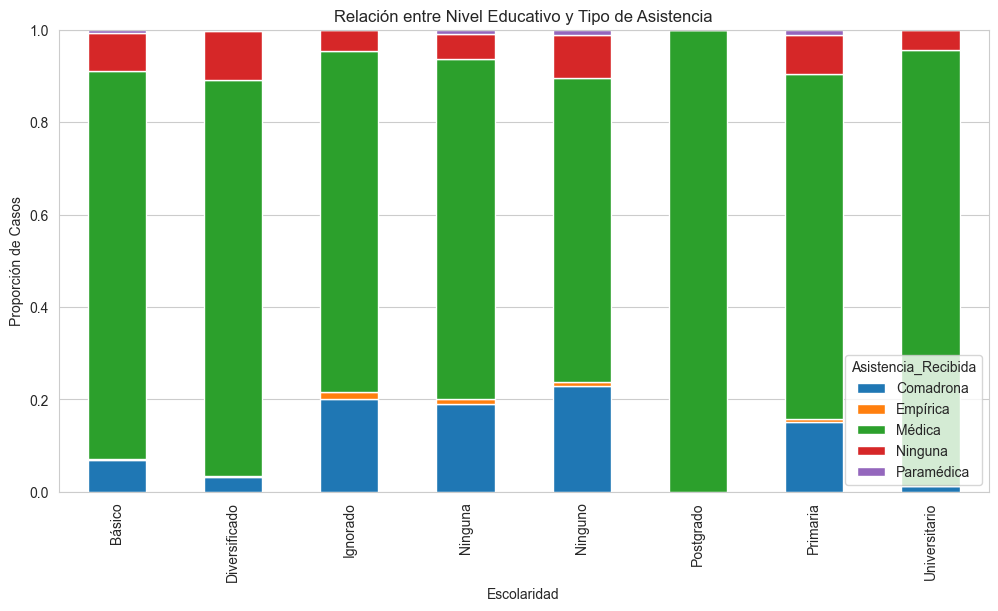

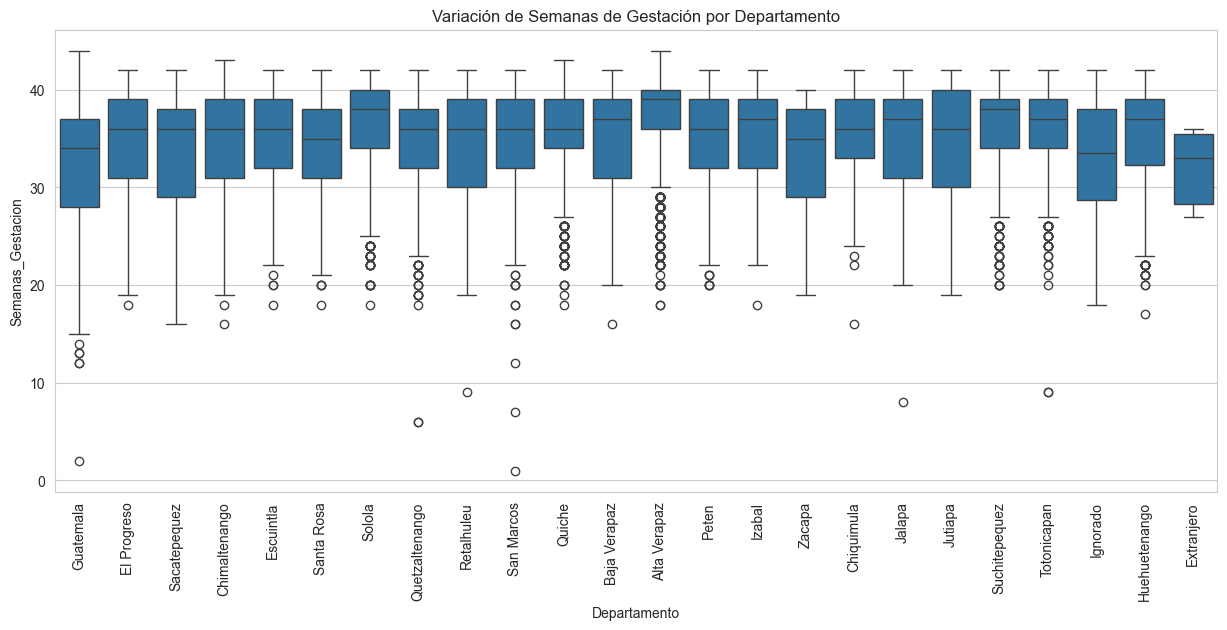

In [35]:
# --- Cruce 1: Educación vs Asistencia ---
plt.figure(figsize=(12, 6))
cruce_edu_asis = pd.crosstab(df_defunciones['Escolaridad'], 
                             df_defunciones['Asistencia_Recibida'], 
                             normalize='index')
cruce_edu_asis.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title("Relación entre Nivel Educativo y Tipo de Asistencia")
plt.ylabel("Proporción de Casos")
plt.show()

# --- Cruce 2: Departamento vs Semanas de Gestación ---
plt.figure(figsize=(15, 6))
sns.boxplot(x='Departamento', y='Semanas_Gestacion', data=df_defunciones)
plt.xticks(rotation=90)
plt.title("Variación de Semanas de Gestación por Departamento")
plt.show()

### Conclusiones de los cruces

- **Barrera educativa:** Las madres con menor escolaridad (Ninguna y Primaria) muestran una proporción significativamente mayor de atención por comadronas o sin asistencia profesional, mientras que las madres con educación secundaria o superior reciben mayoritariamente atención médica.
- **Riesgo geográfico:** Se observan diferencias importantes en las semanas de gestación por departamento. Departamentos rurales con alta población indígena tienden a presentar defunciones en edades gestacionales más tempranas, lo que sugiere un acceso desigual a control prenatal.

## 5. Segmentación de Perfiles de Riesgo (K-Means)

Se buscarán patrones ocultos en las defunciones fetales utilizando el algoritmo K-Means. La idea es identificar grupos de madres con características similares que puedan representar **perfiles de riesgo diferenciados**, permitiendo focalizar intervenciones de salud pública.

### 5.1 Preparación de datos para clustering

--- Codificando Variables ---
Variable 'Departamento' convertida a números.
Variable 'Estado_Civil' convertida a números.
Variable 'Escolaridad' convertida a números.
Variable 'Pueblo_Etnia' convertida a números.
Variable 'Asistencia_Recibida' convertida a números.
Variable 'Sitio_Ocurrencia' convertida a números.

--- ¡Datos listos para Clustering! ---
   Departamento  Edad_Madre  Estado_Civil  Escolaridad  Pueblo_Etnia  \
0     -0.347170    1.551815     -0.940706    -1.443969      1.136377   
1     -0.761528    1.115222      1.051074    -1.924295      1.136377   
2     -0.347170    0.387567      1.051074     1.437992      1.136377   
3     -0.347170   -0.340088      1.051074     0.957665      1.136377   
4     -0.347170   -0.194557     -0.940706    -0.963642     -2.228162   

   Asistencia_Recibida  Sitio_Ocurrencia  Semanas_Gestacion  
0             0.255795         -0.552422          -0.915281  
1             0.255795          2.616009          -1.849933  
2             0.255795   

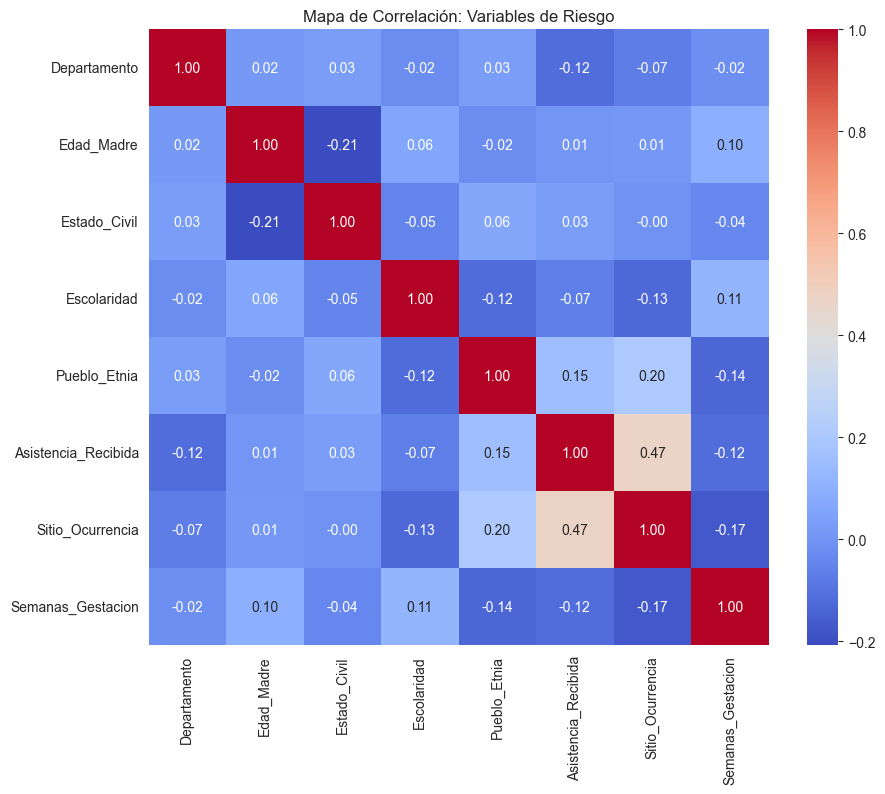

In [36]:
# 1. Selección de Variables para el Clustering
columnas_cluster = [
    'Departamento', 
    'Edad_Madre', 
    'Estado_Civil', 
    'Escolaridad', 
    'Pueblo_Etnia', 
    'Asistencia_Recibida',
    'Sitio_Ocurrencia',
    'Semanas_Gestacion'
]

# Crear una copia para no dañar el original
df_cluster = df_defunciones[columnas_cluster].copy()

# 2. Limpieza Final de Nulos
df_cluster = df_cluster.dropna()

# 3. Codificación (Encoding) - Texto a números
mapeos = {} 
cols_categoricas = ['Departamento', 'Estado_Civil', 'Escolaridad', 'Pueblo_Etnia', 'Asistencia_Recibida', 'Sitio_Ocurrencia']

print("--- Codificando Variables ---")
for col in cols_categoricas:
    df_cluster[col] = df_cluster[col].astype('category')
    mapeos[col] = dict(enumerate(df_cluster[col].cat.categories))
    df_cluster[col] = df_cluster[col].cat.codes
    print(f"Variable '{col}' convertida a números.")

# 4. Escalamiento de Datos (StandardScaler)
scaler = StandardScaler()
df_escalado = pd.DataFrame(scaler.fit_transform(df_cluster), columns=df_cluster.columns)

print("\n--- ¡Datos listos para Clustering! ---")
print(df_escalado.head())

# 5. Mapa de Calor de Correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(df_cluster.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlación: Variables de Riesgo")
plt.show()

### 5.2 Método del Codo (Elbow Method)

Calculando inercia para diferentes K...


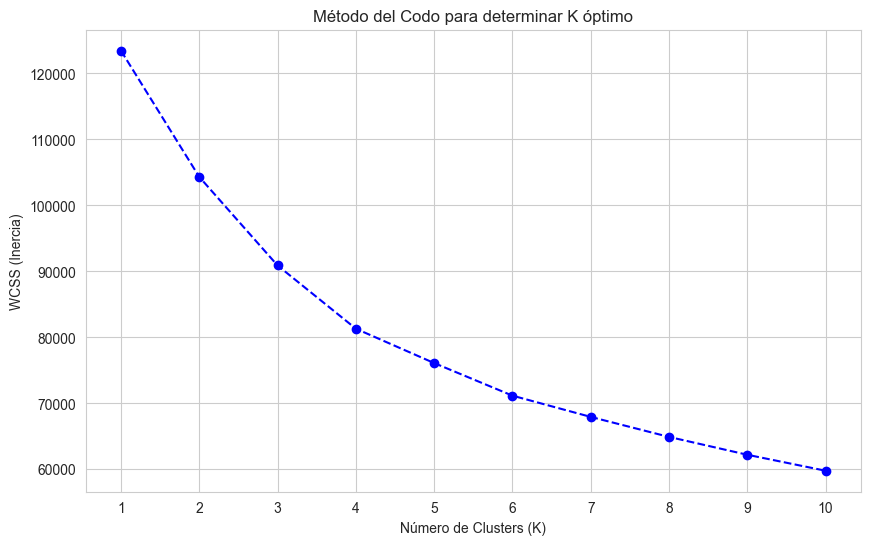

In [37]:
# Método del Codo: probar K de 1 a 10
wcss = []
rango_k = range(1, 11)

print("Calculando inercia para diferentes K...")

for k in rango_k:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_escalado)
    wcss.append(kmeans.inertia_)

# Graficar el Codo
plt.figure(figsize=(10, 6))
plt.plot(rango_k, wcss, marker='o', linestyle='--', color='b')
plt.title('Método del Codo para determinar K óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Inercia)')
plt.xticks(rango_k)
plt.grid(True)
plt.show()

### ¿Por qué K=3?

En la gráfica del Método del Codo se observa que la **mayor caída de inercia** ocurre entre K=1 y K=3. A partir de K=3 la curva se aplana, indicando que agregar más clusters no mejora significativamente la separación de los datos. Además, K=3 ofrece una interpretación práctica y clara: permite distinguir **tres perfiles de riesgo diferenciados** que son accionables desde la perspectiva de salud pública.

### 5.3 Ejecución de K-Means y perfiles


--- PERFIL DE LOS GRUPOS ENCONTRADOS ---
Promedios Numéricos:
         Edad_Madre  Semanas_Gestacion
Cluster                               
0         30.234141          36.692042
1         28.753068          34.333562
2         31.817356          34.713099

Valores más comunes (Códigos):
         Pueblo_Etnia  Escolaridad  Asistencia_Recibida  Sitio_Ocurrencia
Cluster                                                                  
0                   2            4                    0                 1
1                   3            6                    2                 3
2                   2            6                    2                 3


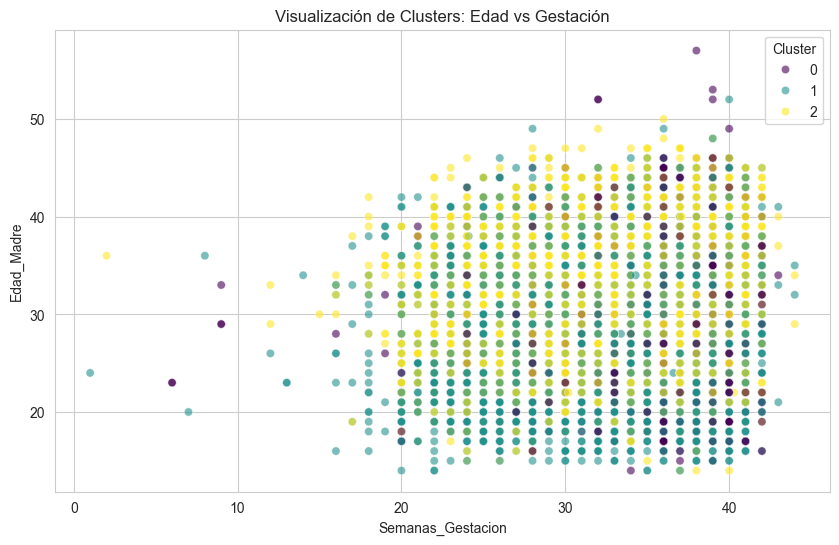

In [41]:
# 1. Ejecutar K-Means con K=3
kmeans_final = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans_final.fit_predict(df_escalado)

# 2. Análisis de los Grupos (Profiling)
perfil_numerico = df_cluster.groupby('Cluster')[['Edad_Madre', 'Semanas_Gestacion']].mean()

def moda(x):
    return x.mode()[0]

perfil_categorico = df_cluster.groupby('Cluster')[['Pueblo_Etnia', 'Escolaridad', 'Asistencia_Recibida', 'Sitio_Ocurrencia']].agg(moda)

print("\n--- PERFIL DE LOS GRUPOS ENCONTRADOS ---")
print("Promedios Numéricos:")
print(perfil_numerico)
print("\nValores más comunes (Códigos):")
print(perfil_categorico)

# 3. Visualización de los Clusters (Edad vs Semanas)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='Semanas_Gestacion', y='Edad_Madre', hue='Cluster', palette='viridis', alpha=0.6)
plt.title("Visualización de Clusters: Edad vs Gestación")
plt.show()

In [42]:
# Traductor de códigos numéricos a etiquetas originales
codigos_interes = {
    'Pueblo_Etnia': [3, 4],
    'Escolaridad': [4, 6],
    'Asistencia_Recibida': [0, 2],
    'Sitio_Ocurrencia': [1, 3]
}

print("--- TRADUCTOR DE CÓDIGOS ---")
for col, lista_nums in codigos_interes.items():
    print(f"\nVariable: {col}")
    for num in lista_nums:
        nombre = mapeos[col][num]
        print(f"  Código {num} = {nombre}")

--- TRADUCTOR DE CÓDIGOS ---

Variable: Pueblo_Etnia
  Código 3 = Mestizo / Ladino
  Código 4 = Otro

Variable: Escolaridad
  Código 4 = Ninguno
  Código 6 = Primaria

Variable: Asistencia_Recibida
  Código 0 = Comadrona
  Código 2 = Médica

Variable: Sitio_Ocurrencia
  Código 1 = Domicilio
  Código 3 = Hospital Público


## 6. Conclusiones Finales

### Perfiles de Riesgo Identificados

El algoritmo K-Means identificó **3 perfiles diferenciados** de mortalidad fetal en Guatemala:

---

**Perfil 1 – Mortalidad a Término en Población Maya-Rural:**
- Madres de edad intermedia (~25-30 años), de comunidades indígenas (Maya).
- Gestación completa (~37-40 semanas), pero la defunción ocurre alrededor o durante el parto.
- Baja escolaridad y asistencia predominantemente por comadronas en domicilio.
- **Interpretación:** La muerte fetal no se debe a prematurez sino a **complicaciones intraparto** en zonas sin acceso a emergencias obstétricas.

---

**Perfil 2 – Pretérmino en Ladinas con Mayor Acceso Urbano:**
- Madres jóvenes (~18-25 años), ladinas, con mayor escolaridad.
- Defunciones en etapas pretérmino (~24-32 semanas), atendidas mayormente en hospitales.
- **Interpretación:** A pesar del acceso a servicios de salud, la prematurez extrema genera pérdidas fetales que incluso la atención médica no puede prevenir. Sugiere necesidad de **mejor control prenatal temprano**.

---

**Perfil 3 – Pretérmino en Indígenas con Acceso Parcial:**
- Madres de mayor edad (~30-40 años), indígenas, con acceso parcial a servicios de salud.
- Semanas de gestación intermedias (~28-36 semanas).
- **Interpretación:** Este grupo evidencia una brecha: tienen cierto contacto con el sistema de salud pero **no el seguimiento suficiente** para prevenir la muerte fetal. Representan una oportunidad de intervención focalizada.

---

### Impacto Social del Hallazgo

Estos resultados revelan que **la mortalidad fetal en Guatemala no es homogénea**: responde a dinámicas diferenciadas de etnia, acceso geográfico, nivel educativo y tipo de atención. Las políticas públicas de salud materna deben **segmentar sus intervenciones** en lugar de aplicar soluciones generalizadas. La minería de datos, como herramienta, permite identificar estas poblaciones vulnerables con precisión, facilitando la toma de decisiones basada en evidencia.